In [1]:
import networkx as nx
import osmnx as ox
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import sys
import pandas as pd
import itertools
ox.__version__

'1.9.4'

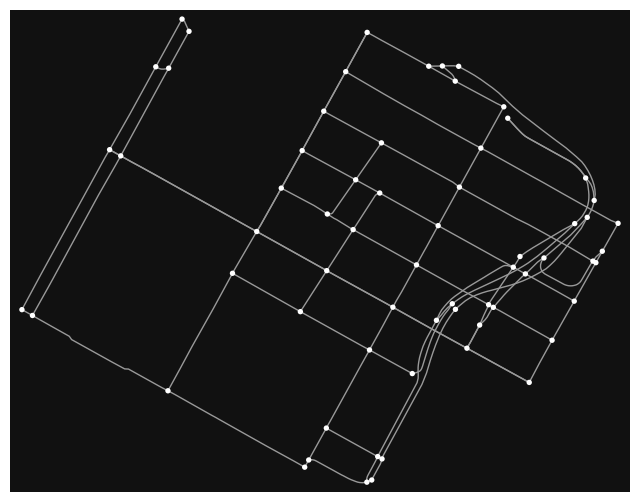

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64))

In [2]:
# download/model a street network for some city then visualize it
G_hy = ox.graph_from_place("Hudson Yards, New York, USA", network_type="drive")
strong = sorted(nx.strongly_connected_components(G_hy), key=len, reverse=True)
G_hy_s = nx.convert_node_labels_to_integers(G_hy.subgraph(strong[0]))
fig, ax = ox.plot_graph(G_hy_s)

coords = [(G_hy_s.nodes[x]['x'],(G_hy_s.nodes[x]['y'])) for x in range(len(G_hy_s.nodes))]
min_max_scaler = MinMaxScaler()
coords_scaled = min_max_scaler.fit_transform(coords)
for i in range(len(G_hy_s.nodes)):
    G_hy_s.nodes[i]['scaled_x'], G_hy_s.nodes[i]['scaled_y'] = coords_scaled[i,0],coords_scaled[i,1]
    
G_hy_s.nodes

In [14]:
import networkx as nx
import random
import matplotlib.pyplot as plt

class Target:
    def __init__(self, node, value):
        self.node = node
        self.value = value

class Player:
    def __init__(self, name, start_node):
        self.name = name
        self.current_node = start_node
        self.path = [start_node]  # Track the path taken
    
    def move(self, new_node):
        self.current_node = new_node
        self.path.append(new_node)

class Attacker(Player):
    def __init__(self, name, start_node):
        super().__init__(name, start_node)

    def choose_target(self, targets):
        # Simple heuristic: pick the target with the highest value
        target = max(targets, key=lambda t: t.value)
        return target

class Defender(Player):
    def __init__(self, name, start_node, capture_radius):
        super().__init__(name, start_node)
        self.capture_radius = capture_radius
    
    def is_attacker_caught(self, attacker):
        # Check if attacker is within capture radius
        path_length = nx.shortest_path_length(game.graph, source=self.current_node, target=attacker.current_node)
        return path_length <= self.capture_radius

class SecurityGame:
    def __init__(self, graph, num_timesteps, attacker_start_nodes, moving_defender_start_nodes, stationary_defender_start_nodes, targets, num_attackers=1, num_moving_defenders=1, num_stationary_defenders=0, allow_wait=True):
        self.graph = graph
        self.num_timesteps = num_timesteps
        self.attacker_start_nodes = attacker_start_nodes
        self.moving_defender_start_nodes = moving_defender_start_nodes
        self.stationary_defender_start_nodes = stationary_defender_start_nodes
        self.num_attackers = num_attackers
        self.num_moving_defenders = num_moving_defenders
        self.num_stationary_defenders = num_stationary_defenders
        self.allow_wait = allow_wait
        self.targets = targets
        
        # Initialize attacker and defender units
        self.attacker_units = [Attacker(f"Attacker {i+1}", start_node) for i, start_node in enumerate(attacker_start_nodes[:num_attackers])]
        self.moving_defender_units = [Defender(f"Moving Defender {i+1}", start_node, capture_radius=1) 
                                      for i, start_node in enumerate(moving_defender_start_nodes[:num_moving_defenders])]
        self.stationary_defender_units = [Defender(f"Stationary Defender {i+1}", start_node, capture_radius=1) 
                                          for i, start_node in enumerate(stationary_defender_start_nodes[:num_stationary_defenders])]

    def generate_strategy_matrix(self, player_type):
        """
        Generates a strategy matrix for the given player (Attacker or Defender) with support for multiple units
        and optionally waiting at nodes during the strategy.
        
        Parameters:
        - player_type: "attacker" or "defender"
        
        Returns:
        - strategy_matrix: 2D numpy array where each row represents a possible path or strategy.
        """
        num_timesteps = self.num_timesteps
        all_paths = []
        allow_wait = self.allow_wait  # Check if waiting is allowed
    
        if player_type == "attacker":
            moving_units = self.attacker_units
            start_nodes = self.attacker_start_nodes
        elif player_type == "defender":
            moving_units = self.moving_defender_units
            stationary_units = self.stationary_defender_units
            start_nodes = self.moving_defender_start_nodes
            stationary_start_nodes = self.stationary_defender_start_nodes
        else:
            raise ValueError("Invalid player_type. Choose 'attacker' or 'defender'.")
    
        # Handle stationary units for defenders (stationary units don't move)
        if player_type == "defender":
            stationary_positions = list(itertools.product(stationary_start_nodes, repeat=len(stationary_units)))
    
        # DFS logic to generate all possible strategies for moving units
        def dfs(current_positions, path):
            if len(path) == num_timesteps:
                all_paths.append(path)
                return
    
            # For each unit, either move to a neighboring node or wait
            for i, current_position in enumerate(current_positions):
                neighbors = list(self.graph.neighbors(current_position))
    
                # If allowed, add the current node as a waiting option
                if allow_wait or not neighbors:
                    dfs(tuple(current_positions), path + [tuple(current_positions)])
    
                for neighbor in neighbors:
                    new_positions = list(current_positions)
                    new_positions[i] = neighbor
                    dfs(tuple(new_positions), path + [tuple(new_positions)])
    
        # Initialize DFS for each moving unit from its allowed starting nodes
        for start_node_combination in itertools.product(start_nodes, repeat=len(moving_units)):
            moving_paths = []
            dfs(start_node_combination, [start_node_combination])
    
            # Combine moving defender strategies with stationary defender positions
            if player_type == "defender":
                for stationary_combination in stationary_positions:
                    # print(stationary_combination)
                    for path in all_paths:
                        combined_path = [(move_pos, stationary_pos) for move_pos, stationary_pos in zip(path, [stationary_combination]*num_timesteps)]
                        print(combined_path)
                        moving_paths.append(combined_path)
    
            else:
                moving_paths = all_paths  # Attackers don't have stationary units
    
        # Convert list of paths to a numpy array for easy manipulation
        strategy_matrix = np.array(moving_paths)
    
        return strategy_matrix


    def visualize_game_state(self, timestep):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(f"Game State at Timestep {timestep + 1}")
        
        # Set axis limits to zoom in on the graph
        ax.set_xlim(self.x_min - 0.05, self.x_max + 0.05)
        ax.set_ylim(self.y_min - 0.05, self.y_max + 0.05)
        
        # Draw nodes and edges with the real-world positions
        nx.draw(self.graph, pos=self.pos, ax=ax, node_color="lightgrey", node_size=100)
        nx.draw_networkx_labels(self.graph, pos=self.pos, font_size=8)

        
        # Mark target nodes with value annotations
        for target in self.targets:
            nx.draw_networkx_nodes(self.graph, pos=self.pos, nodelist=[target.node], node_color="yellow", node_size=100, ax=ax)
            # Adjust the target value annotations to be slightly off the side of the node
            offset = 0.005  # Slight offset to avoid overlap (adjust based on scale)
            x, y = self.pos[target.node]
            ax.annotate(f"{target.value}", xy=(x + offset, y + offset), fontsize=5, ha='center', va='center', color='black')

        # Draw paths for attacker and defender
        nx.draw_networkx_edges(self.graph, pos=self.pos, edgelist=list(zip(self.attacker.path[:-1], self.attacker.path[1:])), ax=ax, edge_color="red", width=2.0)
        nx.draw_networkx_edges(self.graph, pos=self.pos, edgelist=list(zip(self.defender.path[:-1], self.defender.path[1:])), ax=ax, edge_color="blue", width=2.0)

        # Draw attacker and defender positions
        nx.draw_networkx_nodes(self.graph, pos=self.pos, nodelist=[self.attacker.current_node], node_color="red", node_size=100, ax=ax, label="Attacker")
        nx.draw_networkx_nodes(self.graph, pos=self.pos, nodelist=[self.defender.current_node], node_color="blue", node_size=100, ax=ax, label="Defender")
        
        # Highlight the target the attacker is moving towards
        target = self.attacker.choose_target(self.targets)
        nx.draw_networkx_nodes(self.graph, pos=self.pos, nodelist=[target.node], node_color="green", node_size=100, ax=ax, label="Current Target")
        
        # Define a custom legend to show attacker and defender paths, targets, and current target
        handles = [
            plt.Line2D([], [], color='red', label='Attacker Path', linewidth=2),
            plt.Line2D([], [], color='blue', label='Defender Path', linewidth=2),
            plt.Line2D([], [], marker='o', color='yellow', label='Targets', markersize=10, linestyle='None'),
            plt.Line2D([], [], marker='o', color='green', label='Current Target', markersize=10, linestyle='None')
        ]
        ax.legend(handles=handles)
        
        plt.show()
    
    def play_game(self):
        for timestep in range(self.num_timesteps):
            print(f"--- Timestep {timestep + 1} ---")
            
            # Attacker chooses a target
            target = self.attacker.choose_target(self.targets)
            print(f"Attacker is moving towards target at node {target.node} with value {target.value}.")
            
            # Simple movement logic (1 step towards the target)
            path = nx.shortest_path(self.graph, source=self.attacker.current_node, target=target.node)
            if len(path) > 1:
                self.attacker.move(path[1])
            print(f"Attacker moved to node {self.attacker.current_node}.")
            
            # Defender moves (simple random walk for now)
            possible_moves = list(self.graph.neighbors(self.defender.current_node))
            if possible_moves:
                self.defender.move(random.choice(possible_moves))
            print(f"Defender moved to node {self.defender.current_node}.")
            
            # Visualize the current state of the game at each timestep
            self.visualize_game_state(timestep)
            
            # Check if defender catches the attacker
            if self.defender.is_attacker_caught(self.attacker):
                print("Defender caught the attacker!")
                break
            
            # Check if attacker reached the target
            if self.attacker.current_node == target.node:
                print(f"Attacker reached the target and gains {target.value} points!")
                break

    def play_game_with_strategies(self, defender_strategy, attacker_strategy):
        """
        Play the game using specific strategies for both the defenders and attackers.
        The strategies are lists of nodes for each unit (both attackers and defenders).
        """
        # Initialize scores for each attacker
        reached_targets = set()  # This will store target nodes that have been reached
        attacker_scores = [0] * self.num_attackers
        interdicted = [False] * self.num_attackers  # Track which attackers have been interdicted
        
        # Loop over each timestep
        for t in range(self.num_timesteps):
            current_defender_positions = defender_strategy[t]  # Tuple of defender positions (moving, stationary)
            current_attacker_positions = attacker_strategy[t]  # Tuple of attacker positions
            
            # Ensure the node labels are correctly formatted as integers
            current_defender_positions = [
                int(d[0]) if isinstance(d, (list, np.ndarray)) else int(d) 
                for d in current_defender_positions
            ]
            current_attacker_positions = [
                int(a[0]) if isinstance(a, (list, np.ndarray)) else int(a) 
                for a in current_attacker_positions
            ]
            
            # Check for interdictions
            for attacker_idx, attacker_position in enumerate(current_attacker_positions):
                if interdicted[attacker_idx]:
                    continue  # Skip interdicted attackers
                
                # Compare each attacker position with all moving defender positions
                for defender_idx, defender_position in enumerate(current_defender_positions[:self.num_moving_defenders]):
                    if nx.shortest_path_length(self.graph, source=attacker_position, target=defender_position) <= self.moving_defender_units[defender_idx].capture_radius:
                        interdicted[attacker_idx] = True
                        break  # Interdiction occurred for this attacker
                
                # Compare attacker position with all stationary defender positions
                for defender_idx, defender_position in enumerate(current_defender_positions[self.num_moving_defenders:], start=0):
                    if nx.shortest_path_length(self.graph, source=attacker_position, target=defender_position) <= self.stationary_defender_units[defender_idx].capture_radius:
                        interdicted[attacker_idx] = True
                        break  # Interdiction occurred for this attacker
            
                # Update score for this attacker (if not interdicted yet)
                if not interdicted[attacker_idx]:
                    for target in self.targets:
                        if attacker_position == target.node and target.node not in reached_targets:
                            attacker_scores[attacker_idx] += -target.value
                            reached_targets.add(target.node)
        
            # If all attackers are interdicted, end the game early
            if all(interdicted):
                break
        
        # Return the total score (sum of all attackers' scores)
        return sum(attacker_scores)

    def generate_utility_matrix(self):
        """
        Generate the utility matrix by simulating all combinations of strategies
        for both attackers and defenders with multiple units.
        """
    
        defender_matrix = self.generate_strategy_matrix("defender")
        attacker_matrix = self.generate_strategy_matrix("attacker")
    
        utility_matrix = np.zeros((len(defender_matrix), len(attacker_matrix)))
    
        for i, defender_strategy in enumerate(defender_matrix):
            for j, attacker_strategy in enumerate(attacker_matrix):
                utility_matrix[i, j] = self.play_game_with_strategies(defender_strategy, attacker_strategy)
    
        return utility_matrix

    def plot_initial_game_state(self):
        """
        Plots the initial game state showing the graph, player start locations, 
        and target node information without any player paths. Supports both 
        real-world graphs with 'x', 'y' node attributes and simple grid graphs 
        from nx.grid_2d_graph.
        """
        plt.figure(figsize=(8, 6))
    
        # Check if the graph has 'x', 'y' node attributes for positioning
        if 'x' in next(iter(self.graph.nodes(data=True)))[1] and 'y' in next(iter(self.graph.nodes(data=True)))[1]:
            # Use 'x' and 'y' node attributes for positioning
            pos = {node: (self.graph.nodes[node]['x'], self.graph.nodes[node]['y']) for node in self.graph.nodes}
        else:
            # For a grid graph, use the default layout from node labels (tuples like (i, j))
            if isinstance(next(iter(self.graph.nodes)), tuple) and len(next(iter(self.graph.nodes()))) == 2:
                pos = {node: node for node in self.graph.nodes}  # Use (i, j) tuple directly as the position
            else:
                # Fallback to spring layout if no positional info is available
                pos = nx.spring_layout(self.graph)
    
        # Draw the graph
        nx.draw(self.graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, 
                font_color='black', font_weight='bold', edge_color='gray')
    
        # Extract target nodes and their values from the target objects
        target_nodes = [target.node for target in self.targets]
        target_values = [target.value for target in self.targets]
    
        # Draw the target nodes (yellow) and label them with their values
        nx.draw_networkx_nodes(self.graph, pos, nodelist=target_nodes, node_color='yellow', node_size=600)
        
        # Add labels for target node values slightly offset from the node labels
        for i, node in enumerate(target_nodes):
            target_value = target_values[i]
            plt.text(pos[node][0] + 0.05, pos[node][1] + 0.05, f"V={target_value}", fontsize=10, fontweight='bold', color='red')
    
        # Mark attacker and defender starting positions with different colors
        nx.draw_networkx_nodes(self.graph, pos, nodelist=[self.attacker.current_node], node_color='red', node_size=700, label='Attacker Start')
        nx.draw_networkx_nodes(self.graph, pos, nodelist=[self.defender.current_node], node_color='blue', node_size=700, label='Defender Start')
        
        # Add legend for player start locations
        # plt.legend(["Attacker Start", "Defender Start", "Target"], loc='upper right')
        plt.legend(loc='upper right')
    
        plt.title("Initial Game State (Player Starts and Target Values)")
        plt.show()
# Sample graph creation
# G = nx.grid_2d_graph(4, 4)  # A simple 5x5 grid graph
# G = nx.convert_node_labels_to_integers(G)

# Initialize targets randomly
# targets = [Target(node, random.randint(1, 10)) for node in random.sample(list(G_hy_s.nodes), 5)]
# # targets = [Target(node, random.randint(1, 10)) for node in random.sample(list(G.nodes), 5)]


# # Initialize players
# attacker = Attacker(name="Attacker", start_node=6)
# defender = Defender(name="Defender", start_node=15, capture_radius=1)

# # Initialize and play the game with visualization
# game = SecurityGame(graph=G_hy_s, attacker=attacker, defender=defender, targets=targets, num_timesteps=4, force_move=True)
# # game = SecurityGame(graph=G, attacker=attacker, defender=defender, targets=targets, num_timesteps=5, force_move=True)

# print(game.generate_strategy_matrix("attacker"))
# game.play_game()



In [15]:
# Example usage
np.set_printoptions(threshold=sys.maxsize)
G = nx.grid_2d_graph(3, 3)
G = nx.convert_node_labels_to_integers(G)
targets = [Target(4,5), Target(7,3)]
game = SecurityGame(G, num_timesteps=4,
                    attacker_start_nodes=[0, 3],
                    moving_defender_start_nodes=[8, 5],
                    stationary_defender_start_nodes=[2, 6],
                    num_attackers=1, 
                    num_moving_defenders=1, 
                    num_stationary_defenders=1,
                    allow_wait=True,
                    targets = targets
                    )
# targets = [Target((0,1),5), Target((1,1),3)]
# game = SecurityGame(G, num_timesteps=4,
#                     attacker_start_nodes=[(2, 2), (1, 2)],
#                     moving_defender_start_nodes=[(0, 0), (1, 0)],
#                     stationary_defender_start_nodes=[(2, 0), (0, 2)],
#                     num_attackers=1, 
#                     num_moving_defenders=1, 
#                     num_stationary_defenders=1,
#                     allow_wait=True,
#                     )

attacker_strategies = game.generate_strategy_matrix("attacker")
defender_strategies = game.generate_strategy_matrix("defender")


[((8,), (2,)), ((8,), (2,)), ((8,), (2,)), ((8,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((8,), (2,)), ((5,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((8,), (2,)), ((7,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((5,), (2,)), ((5,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((5,), (2,)), ((2,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((5,), (2,)), ((4,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((5,), (2,)), ((8,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((7,), (2,)), ((7,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((7,), (2,)), ((4,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((7,), (2,)), ((6,), (2,))]
[((8,), (2,)), ((8,), (2,)), ((7,), (2,)), ((8,), (2,))]
[((8,), (2,)), ((5,), (2,)), ((5,), (2,)), ((5,), (2,))]
[((8,), (2,)), ((5,), (2,)), ((5,), (2,)), ((2,), (2,))]
[((8,), (2,)), ((5,), (2,)), ((5,), (2,)), ((4,), (2,))]
[((8,), (2,)), ((5,), (2,)), ((5,), (2,)), ((8,), (2,))]
[((8,), (2,)), ((5,), (2,)), ((2,), (2,)), ((2,), (2,))]
[((8,), (2,)), ((5,), (2,)), ((2,), (2,)), ((1,), (2,))]
[((8,), (2,)), ((5,), (2,)), ((

In [6]:
def format_attacker_strategies(strategy_matrix):
    """
    Post-processes the attacker strategy matrix to a 2D array where each row is a strategy
    and each column corresponds to a timestep. Supports multiple attackers, and squeezes
    any extra dimensions.
    
    Input:
    - strategy_matrix: 3D numpy array of shape (num_strategies, num_timesteps, num_attackers)
    
    Returns:
    - 2D numpy array where each row is a strategy and each column corresponds to a timestep.
      If there's only one attacker, it removes the extra dimension.
    """
    num_strategies, num_timesteps, num_attackers = strategy_matrix.shape
    
    # Squeeze out the extra dimension if there's only one attacker
    if num_attackers == 1:
        formatted_strategies = np.squeeze(strategy_matrix, axis=2)
    else:
        formatted_strategies = []
        for strategy in strategy_matrix:
            formatted_strategy = []
            for timestep in range(num_timesteps):
                attacker_positions = tuple(strategy[timestep][a] for a in range(num_attackers))
                formatted_strategy.append(attacker_positions)
            formatted_strategies.append(formatted_strategy)
        
        formatted_strategies = np.array(formatted_strategies)
    
    return formatted_strategies

In [7]:
print(len(format_attacker_strategies(attacker_strategies)))
format_attacker_strategies(attacker_strategies)

99


array([[0, 0, 0, 0],
       [0, 0, 0, 3],
       [0, 0, 0, 1],
       [0, 0, 3, 3],
       [0, 0, 3, 0],
       [0, 0, 3, 6],
       [0, 0, 3, 4],
       [0, 0, 1, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 4],
       [0, 0, 1, 2],
       [0, 3, 3, 3],
       [0, 3, 3, 0],
       [0, 3, 3, 6],
       [0, 3, 3, 4],
       [0, 3, 0, 0],
       [0, 3, 0, 3],
       [0, 3, 0, 1],
       [0, 3, 6, 6],
       [0, 3, 6, 3],
       [0, 3, 6, 7],
       [0, 3, 4, 4],
       [0, 3, 4, 1],
       [0, 3, 4, 3],
       [0, 3, 4, 7],
       [0, 3, 4, 5],
       [0, 1, 1, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 4],
       [0, 1, 1, 2],
       [0, 1, 0, 0],
       [0, 1, 0, 3],
       [0, 1, 0, 1],
       [0, 1, 4, 4],
       [0, 1, 4, 1],
       [0, 1, 4, 3],
       [0, 1, 4, 7],
       [0, 1, 4, 5],
       [0, 1, 2, 2],
       [0, 1, 2, 1],
       [0, 1, 2, 5],
       [3, 3, 3, 3],
       [3, 3, 3, 0],
       [3, 3, 3, 6],
       [3, 3, 3, 4],
       [3, 3, 0, 0],
       [3, 3, 0, 3],
       [3, 3,

In [5]:
def format_defender_strategies(strategy_matrix):
    """
    Post-processes the defender strategy matrix to a 2D array where each row is a strategy
    and each column corresponds to a timestep. Supports multiple defenders, and squeezes
    any extra dimensions.
    
    Input:
    - strategy_matrix: 4D numpy array of shape (num_strategies, num_timesteps, num_defenders, 1)
    
    Returns:
    - 2D numpy array where each row is a strategy and each column corresponds to a timestep.
      If there's only one defender, it removes the extra dimension.
    """
    num_strategies, num_timesteps, num_defenders, _ = strategy_matrix.shape
    
    # Squeeze out the extra dimension if there's only one defender
    if num_defenders == 1:
        formatted_strategies = np.squeeze(strategy_matrix, axis=2)
    else:
        formatted_strategies = []
        for strategy in strategy_matrix:
            formatted_strategy = []
            for timestep in range(num_timesteps):
                defender_positions = tuple(strategy[timestep][d][0] for d in range(num_defenders))
                formatted_strategy.append(defender_positions)
            formatted_strategies.append(formatted_strategy)
        
        formatted_strategies = np.array(formatted_strategies)
    
    return formatted_strategies

In [10]:
# format_defender_strategies(defender_strategies)
defender_strategies

array([[[[8],
         [2]],

        [[8],
         [2]],

        [[8],
         [2]],

        [[8],
         [2]]],


       [[[8],
         [2]],

        [[8],
         [2]],

        [[8],
         [2]],

        [[5],
         [2]]],


       [[[8],
         [2]],

        [[8],
         [2]],

        [[8],
         [2]],

        [[7],
         [2]]],


       [[[8],
         [2]],

        [[8],
         [2]],

        [[5],
         [2]],

        [[5],
         [2]]],


       [[[8],
         [2]],

        [[8],
         [2]],

        [[5],
         [2]],

        [[2],
         [2]]],


       [[[8],
         [2]],

        [[8],
         [2]],

        [[5],
         [2]],

        [[4],
         [2]]],


       [[[8],
         [2]],

        [[8],
         [2]],

        [[5],
         [2]],

        [[8],
         [2]]],


       [[[8],
         [2]],

        [[8],
         [2]],

        [[7],
         [2]],

        [[7],
         [2]]],


       [[[8],
         [

In [8]:
m = game.generate_utility_matrix()

In [9]:
m

array([[ 0.,  0.,  0.,  0.,  0.,  0., -5.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -5.,  0.,  0.,  0.,  0.,  0.,  0., -5., -5., -5., -5., -5.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -5.,  0.,  0.,  0.,  0.,  0.,  0., -5.,
        -5., -5., -5., -5.,  0.,  0.,  0.,  0.,  0.,  0., -5.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -5.,  0.,  0.,  0.,  0.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -3., -5., -5., -5., -8., -5.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -3., -5.,
        -5., -5., -8., -5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
  

In [56]:
max_index = np.argmin(m)
max_coordinates = np.unravel_index(max_index, m.shape)
print("------UTILITY MATRIX MAX COORDS-------")
print(max_coordinates)

------UTILITY MATRIX MAX COORDS-------
(1, 24)


In [57]:
format_defender_strategies(defender_strategies)[1]

array([[8, 2],
       [8, 2],
       [8, 2],
       [5, 2]])

In [58]:
format_attacker_strategies(attacker_strategies)[24]

array([0, 3, 4, 7])

In [60]:
m[1,24]

-8.0